In [1]:
import sys
import numpy as np
import rioxarray
import rasterio as rio
import xarray as xr 
import os
import pandas as pd
from scipy.stats import gamma
from scipy.stats import norm
import matplotlib.pyplot as plt
import geopandas as gpd
import glob
from datetime import datetime
from geocube.api.core import make_geocube
 
os.chdir("C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/IBF_DROUGHT_PIPELINE/pipeline/lib")
from climate_indices import compute, indices, utils

%matplotlib inline
%load_ext autoreload

In [16]:
prediction_data='2022-01-01'
#prediction 
df_obs_ =xr.open_dataset("C:/data/icpac/ObservedRain_Mar-May_Feb2022.nc",decode_times=False)
df_prediction_ =xr.open_dataset("C:/data/icpac/PredictedRain_Mar-May_Feb2022.nc",decode_times=False)#.rename({"band": "time"})
admin_df =gpd.read_file('C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/IBF_DROUGHT_PIPELINE/pipeline/data/input/admin2.geojson')
### create a new unique identifier with type integer 
admin_df['ind'] = admin_df.apply(lambda row: row.ADM2_PCODE[-4:], axis=1)
admin_df["pcode"] = admin_df.ind.astype(int)
 
## this can also be in geotiff format 
lhz_df =gpd.read_file('C:/Users/ATeklesadik/OneDrive - Rode Kruis/Documents/documents/IBF_DROUGHT_PIPELINE/pipeline/data/input/eth_lhz.geoson.geojson')
### create a new unique identifier with type integer 
lhz_df["cropzone"] = lhz_df.cropzone.astype(int)


# correct/define time dimension 
df_obs_['time'] = pd.date_range(start='1982-05-01', periods=df_obs_.sizes['time'], freq='12M') 
df_prediction_=xr.concat([df_prediction_["prec"]/3, df_prediction_["prec"]/3,df_prediction_["prec"]/3], dim="time")
df_prediction_['time'] = pd.date_range(start=prediction_data, periods=3, freq='M')

In [3]:
############### historical data 
min_lon = 20.5
min_lat = -13.5
max_lon = 53.0
max_lat =24.5
geotiff_list = glob.glob('C:/data/icpac/tiff/chirps-*.tif')
time_var = xr.Variable('time',[datetime.strptime(items.split('\\')[-1][12:19], '%Y.%m') for items in geotiff_list])

import rioxarray as rio

def open_clip_tiff(filename,df_prediction_):
    t=rio.open_rasterio(filename).rio.write_crs("epsg:4326", inplace=True).rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat).sel(band=1).drop("band")
    t=t.where(t>0)
    t=t.rename({'x':'lon','y':'lat'})
    #interpolate into the higher resolution grid from IMERG
    interp_t= t.interp(lat=df_prediction_["lat"], lon=df_prediction_["lon"])
    return interp_t

time_var = xr.Variable('time',[datetime.strptime(items.split('\\')[-1][12:19], '%Y.%m') for items in geotiff_list])
geotiffs_da = xr.concat([open_clip_tiff(i,df_prediction_) for i in geotiff_list], dim=time_var)
geotiffs_ds = geotiffs_da.to_dataset(name='prec')

In [4]:
# make sure we have the arrays with time as the inner-most dimension
preferred_dims = ('lat', 'lon', 'time')
df_prediction_1 = df_prediction_.transpose(*preferred_dims)
observation = geotiffs_ds['prec'].transpose(*preferred_dims)
#create one time sereies 
data3 = xr.concat([observation, df_prediction_], dim="time")
#data3['time'] = pd.date_range(start='2000-04-01', periods=data3.sizes['time'], freq='12M') 
 
data_icpac=data3.rename({"lat": "y","lon":"x"}).rio.write_crs("epsg:4326", inplace=True)#.rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat)
data_icpac=data_icpac.rename({"y": "lat","x":"lon"})
# make sure we have the arrays with time as the inner-most dimension
preferred_dims = ('lat', 'lon', 'time')
data_icpac = data_icpac.transpose(*preferred_dims)
data_icpac['time']=pd.date_range(start=data_icpac['time'][0].values, periods=len(data_icpac['time'].values), freq='M')

In [5]:
data_arrays = {
    "low": data_icpac
}

for label, da in data_arrays.items():
    if da['lat'][0] > da['lat'][1]:
        print(f"The {label}-resolution DataArray's lats are descending -- flipping")
        da['lat'] = np.flip(da['lat'])
    if da['lon'][0] > da['lon'][1]:
        print(f"The {label}-resolution DataArray's lons are descending -- flipping")
        da['lon'] = np.flip(da['lon'])

da_precip_lo=data_arrays['low']
initial_year = int(data_icpac['time'][0].dt.year)
scale_months = 3

In [7]:
def apply_spi_gamma_monthly(
    data_array: xr.DataArray,
    months: int,
    data_start_year: int = 2000,
    calibration_year_initial: int = 2000,
    calibration_year_final: int = 2020,
) -> xr.DataArray:

    # stack the lat and lon dimensions into a new dimension named point, so at each lat/lon
    # we'll have a time series for the geospatial point, and group by these points
    da_precip_groupby = data_array.stack(point=('lat', 'lon')).groupby('point')

    spi_args = {
            'scale': months,
            'distribution': indices.Distribution.gamma,
            'data_start_year': data_start_year,
            'calibration_year_initial': calibration_year_initial,
            'calibration_year_final': calibration_year_final,
            'periodicity': compute.Periodicity.monthly
    }

    # apply the SPI function to the data array
    da_spi = xr.apply_ufunc(
        indices.spi,
        da_precip_groupby,
        kwargs=spi_args,
    )

    # unstack the array back into original dimensions
    da_spi = da_spi.unstack('point')
    
    return da_spi

In [8]:
da_spi_lo = apply_spi_gamma_monthly(da_precip_lo, 3)
    
da_precip_hi = da_spi_lo.transpose('lat', 'lon', 'time')
spi_data=da_precip_hi.to_dataset(name='spi3')

In [9]:
def is_amj(month):
    return (month >= 4) & (month <= 4)
    
seasonal_data_april = spi_data.sel(time=is_amj(spi_data['time.month']))

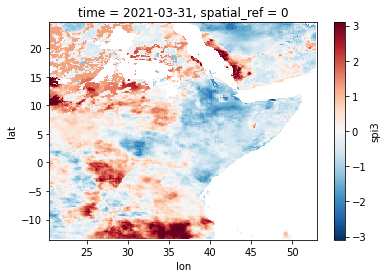

In [11]:
spi_data.spi3.sel(time='2021-03-31T00:00:00.000000000').plot()

In [28]:
 


############### historical data 
min_lon = admin_df.total_bounds[0]
min_lat = admin_df.total_bounds[1]
max_lon =admin_df.total_bounds[2]
max_lat =admin_df.total_bounds[3]

min_lon = 32.9
min_lat = 3.4
max_lon = 48
max_lat =14.9

df_prediction =rioxarray.open_rasterio("C:/data/icpac/PredictedProbabilityRain_Feb_Jan2022.nc")
    ### if the raster file has multiple formats select the band which is relevant for the analysis
precipitation=df_prediction['below'].rio.write_crs("epsg:4326", inplace=True).rio.clip_box(minx=min_lon, miny=min_lat, maxx=max_lon, maxy=max_lat).sel(band=1).drop("band")


2022-04-29  15:57:37 WARNING CPLE_AppDefined in Recode from UTF-8 to CP_ACP failed with the error: "Invalid argument".
2022-04-29  15:57:37 WARNING CPLE_AppDefined in Recode from UTF-8 to CP_ACP failed with the error: "Invalid argument".
2022-04-29  15:57:37 WARNING CPLE_AppDefined in Recode from UTF-8 to CP_ACP failed with the error: "Invalid argument".
2022-04-29  15:57:37 WARNING CPLE_AppDefined in Recode from UTF-8 to CP_ACP failed with the error: "Invalid argument".


In [62]:
min_lon = admin_df.total_bounds[0]
min_lat = admin_df.total_bounds[1]
max_lon =admin_df.total_bounds[2]
max_lat =admin_df.total_bounds[3]
admin_df.total_bounds


array([32.9918    ,  3.40667   , 47.98824   , 14.84547691])

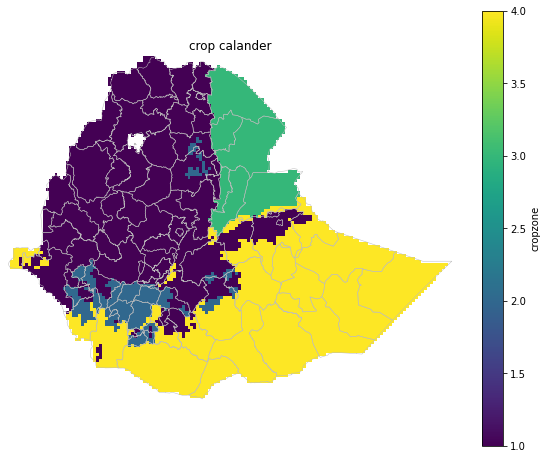

In [33]:

# make your geo cube 
out_grid = make_geocube(
    vector_data=lhz_df,
    measurements=["cropzone"],
    like=precipitation, # ensure the data are on the same grid
)


cropzone=out_grid['cropzone'].to_dataset()

# make your geo cube for admin layer
out_grid = make_geocube(
    vector_data=admin_df,
    measurements=["pcode"],
    like=cropzone, # ensure the data are on the same grid
)


out_grid=out_grid.drop('spatial_ref')
cropzone=cropzone.drop('spatial_ref')
crop_zone=cropzone['cropzone']
#out_grid["seasonal"] = (sesonal_precipitation.dims, sesonal_precipitation.values, sesonal_precipitation.attrs, sesonal_precipitation.encoding)
out_grid["cropzone"] = (crop_zone.dims, crop_zone.values)

f, ax = plt.subplots(figsize=(10, 8))

out_grid.cropzone.plot()#legend=True,legend_kwds={'label': "30th Total Rain for Jun-Sep rainfall average ",'orientation': "horizontal"})
ax.set_title("crop calander")
ax.set_axis_off()
admin_df.boundary.plot(ax=ax,color='#bdbdbd',linewidth=0.5)#,legend_kwds={'label': "30th Total Rain for Jun-Sep rainfall average ",'orientation': "horizontal"})
plt.show() 

In [82]:
def is_amj(month):
    return (month >= 4) & (month <= 4)

min_lon = 20.5
min_lat = -13.5
max_lon = 53.0
max_lat =24.5



seasonal_data_april = spi_data.sel(time=is_amj(spi_data['time.month']))
#seasonal_data_april=seasonal_data_april.rename({"lat": "y","lon":"x"})





In [83]:
 

ds_masked_ = seasonal_data_april#.where(forecast_df_all != -9999) 
 
df_prediction_1=seasonal_data_april.where(seasonal_data_april['spi3'] < -1.2) 

np.datetime_as_string(df_prediction_1.time.values[0], unit='Y')

'2000'

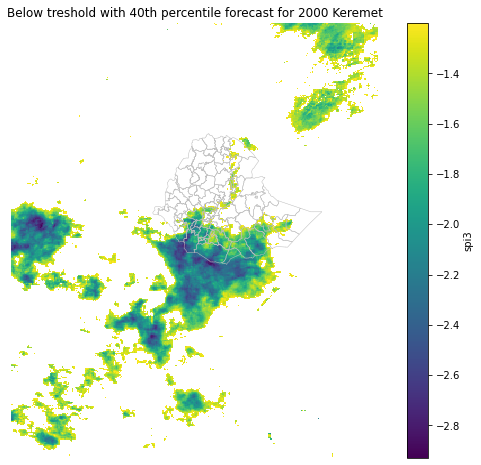

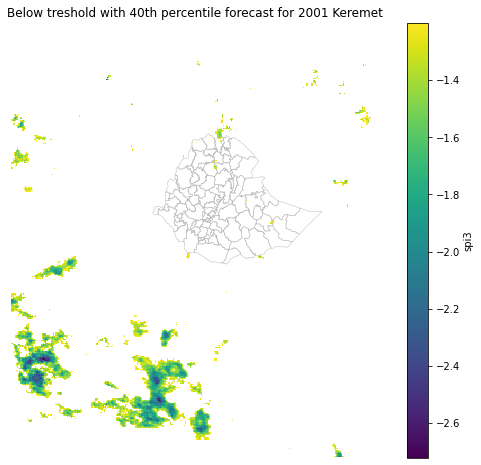

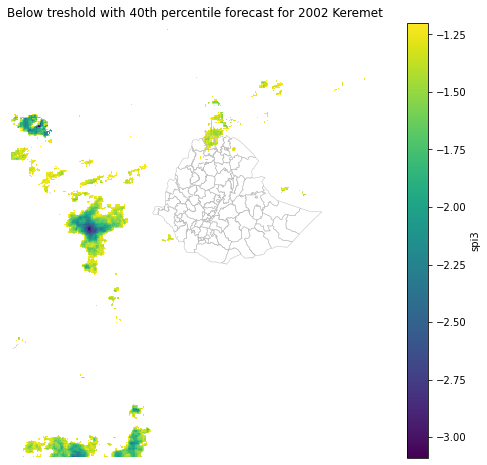

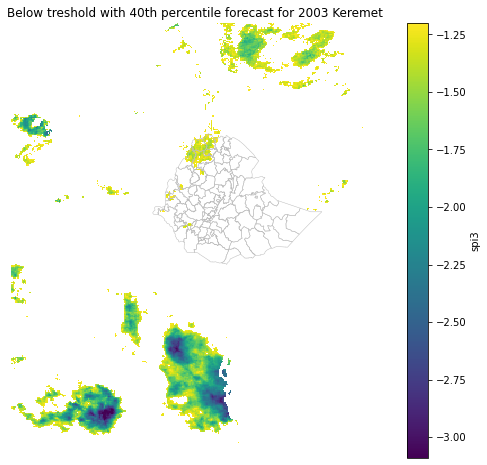

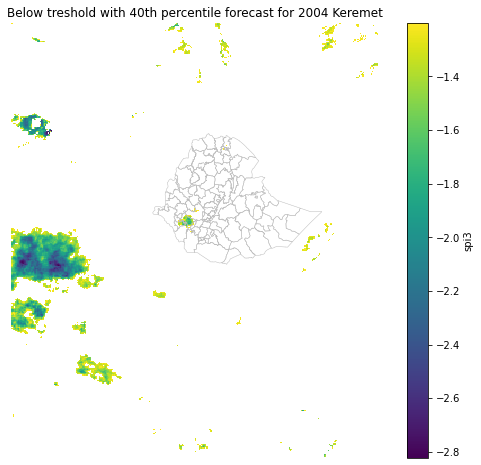

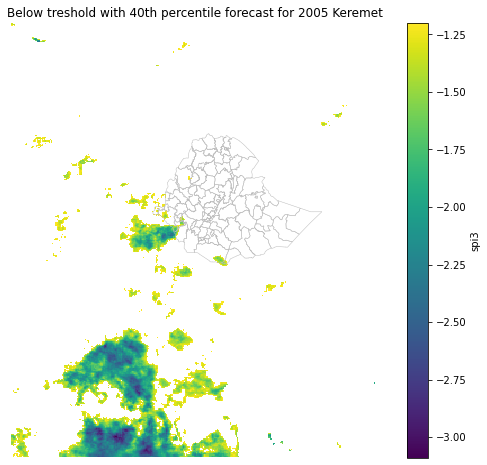

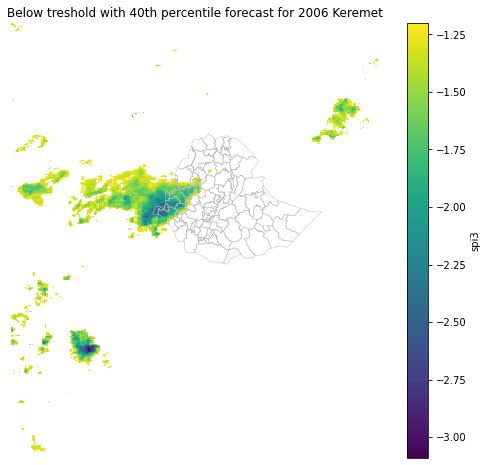

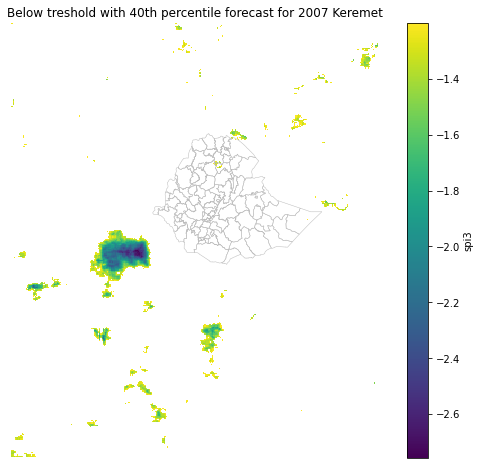

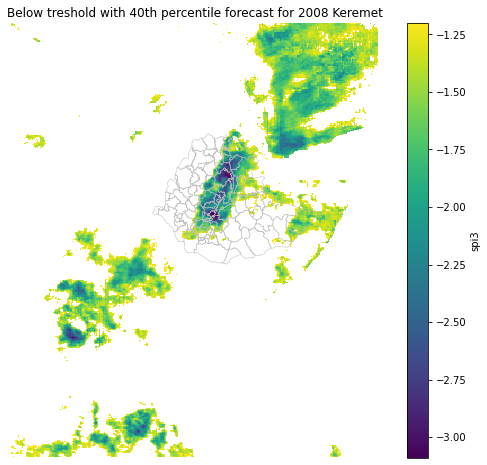

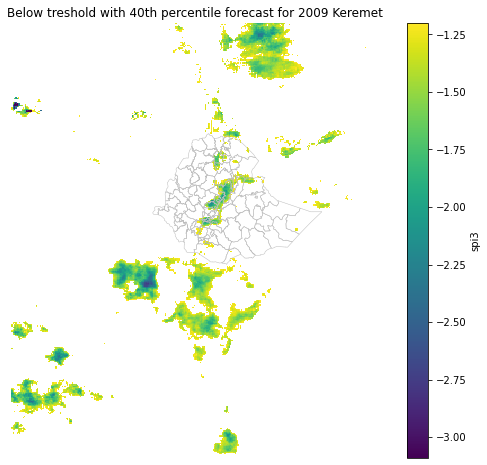

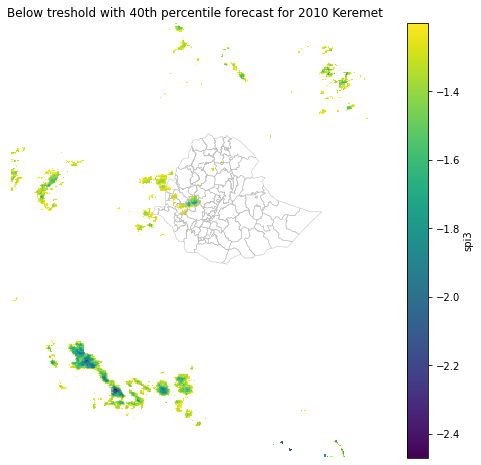

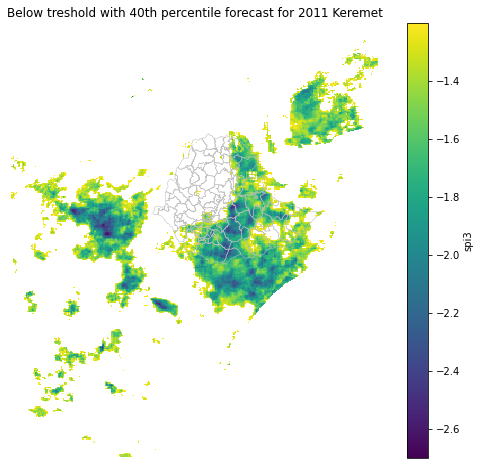

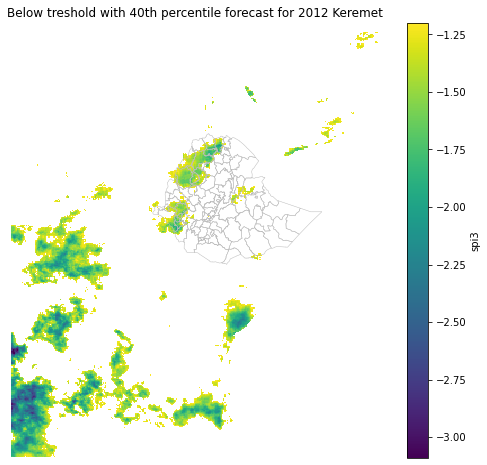

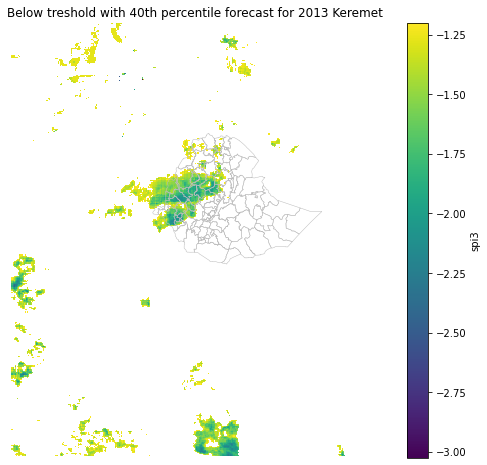

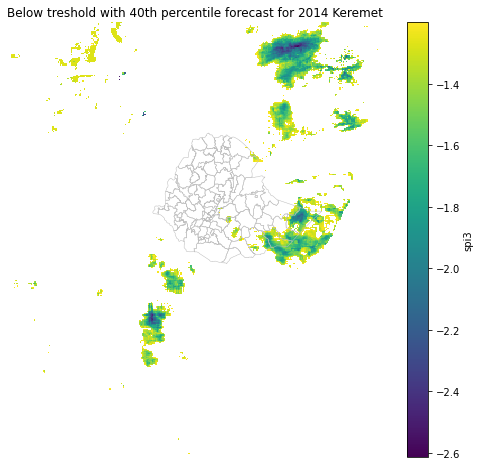

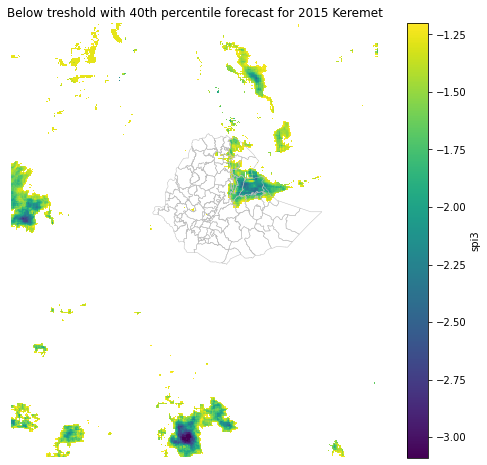

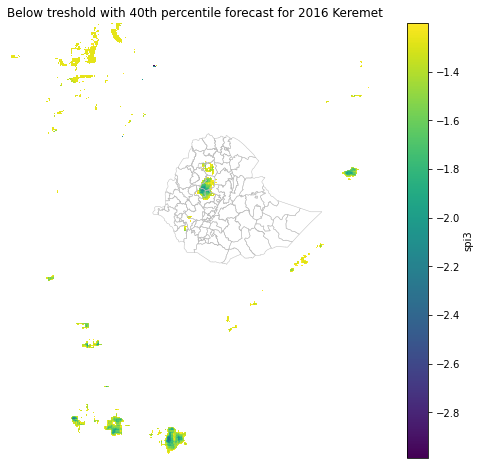

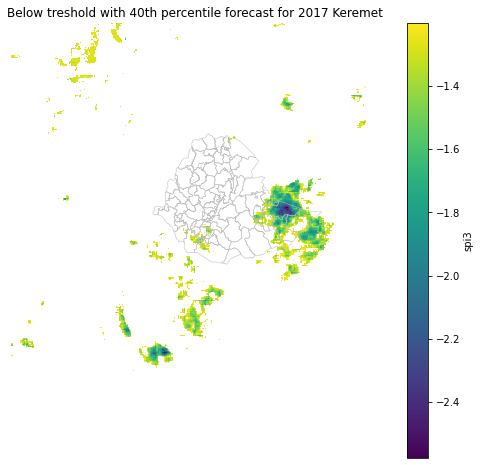

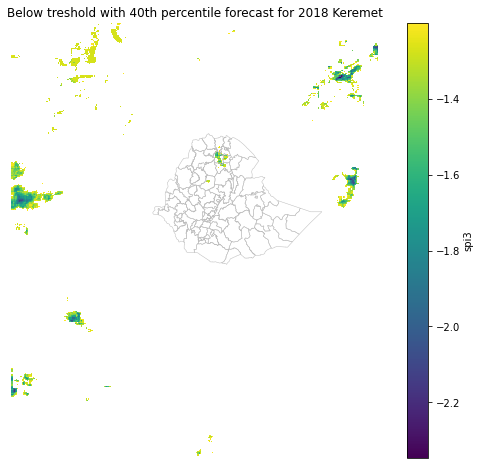

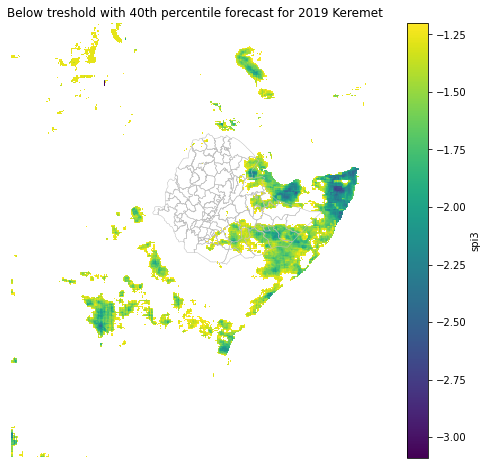

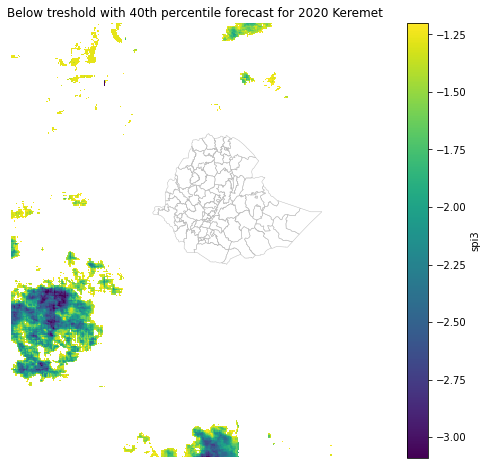

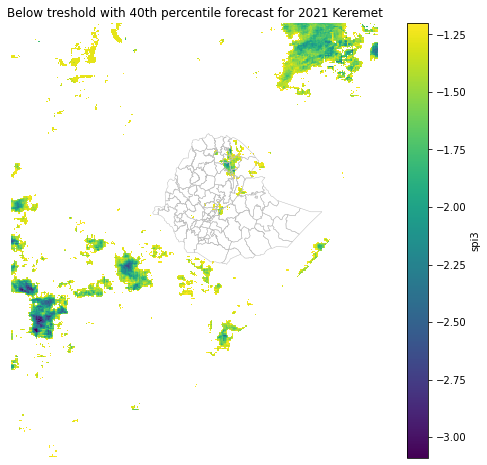

In [51]:


for i in df_prediction_1.time.values:
    df_prediction=df_prediction_1.sel(time=i).drop(['time','spatial_ref'])#.to_dataset()
    year_val=np.datetime_as_string(i, unit='Y')
 
    dff=df_prediction

    dff1=dff['spi3']
    out_grid[f'{year_val}'] = (dff1.dims, dff1.values, dff1.attrs, dff1.encoding)
    f, ax = plt.subplots(figsize=(10, 8))
    dff.spi3.plot()
    ax.set_title(f"Below treshold with 40th percentile forecast for {year_val} Keremet")
    ax.set_axis_off()
    admin_df.boundary.plot(ax=ax,color='#bdbdbd',linewidth=0.5)
    plt.show()

In [ ]:

from geocube.api.core import make_geocube
df_prediction =rioxarray.open_rasterio("C:/data/icpac/PredictedProbabilityRain_Feb_Jan2022.nc")
    ### if the raster file has multiple formats select the band which is relevant for the analysis


precipitation=df_prediction['below']
